# IIW 2021 joint intermediate meeting C-I, C-IV, C-XII, SG-212
This notebook is an extended interactive version of the `weldx` features and example dataset presented at the **2021 IIW joint intermediate meeting of C-I, C-IV, C-XII & SG-212**.

The code of this notebook can be found here: https://github.com/BAMWelDX/IIW2021_joint_intermediate_CXII

You can launch this notebook as an interactive binder session in your browser following this link: \
https://mybinder.org/v2/gh/BAMWelDX/IIW_2021_joint_intermediate_CXII/main?urlpath=lab/tree/iiw2021_CXII_fabry_cagtay_01.ipynb

The `weldx` documentation and code is available online:\
https://weldx.readthedocs.io/en/latest/ \
https://github.com/BAMWelDX/weldx

The `weldx` documentation and GitHub links for this specific code version `v0.3.3` can be found here:\
https://weldx.readthedocs.io/en/v0.3.3/index.html \
https://github.com/BAMWelDX/weldx/tree/v0.3.3



## Process Video
To give an ovierview of this welding example, here is a video recording of the welding experiment conducted at BAM.

We can see the pre- and post-welding scan of the workpiece geometry as well as the position of the temperature measurements.

<video controls src="./data/WID417.webm" />

## Imports
We start with some general python package imports used throughout this notebook.

In [1]:
import pprint
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import asdf
import weldx
from weldx import Q_, WeldxFile
from weldx.asdf.util import view_tree

pp = pprint.PrettyPrinter(indent=2)
pprint = pp.pprint

Some helper functions for this notebook are included in the `helpers.py` file.

In [2]:
from helpers import (
    add_axis_labels_3d,
    ax_setup,
    build_base_csm,
    create_geometry,
    cs_colors,
    plot_gmaw,
    plot_measurements,
    plot_signal,
    welding_wire_geo_data,
    ipympl_style
)

## opening the file
To open and access the file contents we will use the `asdf` library to open the weldx example dataset.

We define the ASDF filename that contains the data used for this notebook.

In [3]:
wx_file = WeldxFile("./data/single_pass_weld.asdf", "r")

In [4]:
filename = "./data/single_pass_weld.asdf"

To get an overview of the file contents we can use the `asdf_json_repr` function of the weldx library to create an interactive tree view.

Try searching for a specific term like `wire_feedrate` using the ***Filter...*** box in the upper right.

In [5]:
view_tree(filename)

<IPython.core.display.JSON object>

The file is expected to validate against the schema `single_pass_weld-1.0.0.schema.yaml`.\
The details describing the schema requirements can be found here: https://weldx.readthedocs.io/en/v0.3.3/generated/weldx.bam.de/weldx/datamodels/single_pass_weld-1.0.0.schema.html

In [6]:
file_schema = (
    Path(weldx.__path__[0])
    / Path(
        "./asdf/schemas/weldx.bam.de/weldx/datamodels/single_pass_weld-1.0.0.schema.yaml"
    ).as_posix()
)

We open the weldx file and run a validation agains the `single_pass_weld-1.0.0.schema.yaml` schema.\
The validation ensures that all elements of the weldx file pass the requirements defined in the schema, including:
- all requirement entries are present in the file:
  - `workpiece`
  - `TCP`
  - `welding_current`
  - `welding_voltage`
  - `measurement chains`
  - `equipment`
- all entries and objects stored in the file have the correct type
- all additional restrictions defined in `single_pass_weld-1.0.0.schema.yaml` are met

In [7]:
with asdf.open(filename, custom_schema=file_schema) as asdf_file:
    weldx_file = asdf_file.tree

## general metadata
First let's look at some general simple metadata stored in the WelDX-file.

The (optional) `reference_timestamp` field is used to indicate the start time of the experiment (the moment of arc ignition). All time data that is not given as absolute time are interpreted as relative to the given reference time.

In [8]:
weldx_file.get("reference_timestamp")

Timestamp('2021-03-17 11:06:42.334400')

We can deduce the total runtime of the experiment from the TCP movement of the welding.

In [9]:
pd.TimedeltaIndex(weldx_file["TCP"].time)

TimedeltaIndex(['0 days 00:00:00', '0 days 00:00:41.333333333'], dtype='timedelta64[ns]', freq=None)

The WelDX standard introduces the `wx_user` field to store user specific content.

In [10]:
weldx_file.get("wx_user")

{'WID': 417, 'operator': 'C. Schippereit', 'project': 'WelDX presentation'}

We define a time index from start to end of the experiment.

In [11]:
t = pd.TimedeltaIndex(weldx_file["TCP"].time[[0, -1]])

## workpiece definition
The file schema mandates that the user provides workpiece information with the following properties:
- `base_metal` referenced by a common name and the associated standard
- the `geometry` consisting of a groove description following ISO 9692-1 and the seam length

Here is how this information is stored the `workpiece` entry of the example dataset weldx file:
```yaml
workpiece:
  base_metal: {common_name: 'S355J2+N', standard: 'DIN EN 10225-2:2011'}
  geometry:
    groove_shape: !<tag:weldx.bam.de:weldx/groove/iso_9692_1_2013_12/VGroove-1.0.0>
      t: !unit/quantity-1.1.0 {unit: millimeter, value: 8}
      alpha: !unit/quantity-1.1.0 {unit: degree, value: 45}
      b: !unit/quantity-1.1.0 {unit: millimeter, value: 1}
      c: !unit/quantity-1.1.0 {unit: millimeter, value: 1}
    seam_length: !unit/quantity-1.1.0 {unit: millimeter, value: 350}
```

### workpiece material

Since we know exactly where to find the information in the file, we can access the metadata directly for all files that validate against the file schema.

In [12]:
weldx_file["workpiece"]["base_metal"]["common_name"]

'S355J2+N'

In [13]:
weldx_file["workpiece"]["base_metal"]["standard"]

'DIN EN 10225-2:2011'

### seam length

The total seam length of the workpiece is also stored.\
As throughout most of the functionality of the `weldx` API, physical units must be used where appropriate to avoid ambiguity.

In [14]:
seam_length = weldx_file["workpiece"]["geometry"]["seam_length"]
print(seam_length)

350 millimeter


### welding groove

The groove shape will be loaded into a specific weldx type:

In [15]:
groove = weldx_file["workpiece"]["geometry"]["groove_shape"]
str(groove)

"VGroove(t=<Quantity(8, 'millimeter')>, alpha=<Quantity(45, 'degree')>, c=<Quantity(1, 'millimeter')>, b=<Quantity(1, 'millimeter')>, code_number=['1.3', '1.5'])"

The `weldx` API includes convinient functions to create and visualize different welding groove shapes.\
Many examples and details are available in this tutorial: https://weldx.readthedocs.io/en/v0.3.3/tutorials/groove_types_01.html

To get a picture of the groove shape we can simply call the `plot` function.

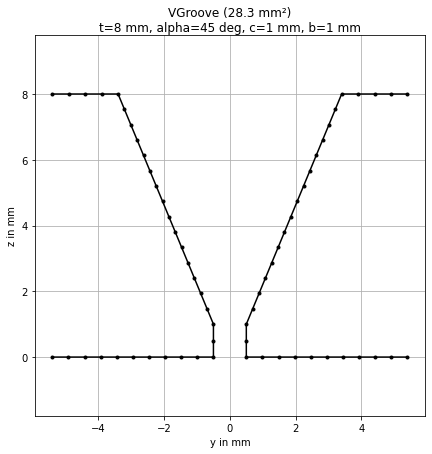

In [16]:
groove.plot()
fig = plt.gcf(); fig.set_size_inches(7, 7);

### 3D Geometry
With all the metadata of the workpiece available, it is easy to visualize a simple 3D model of the specimen.

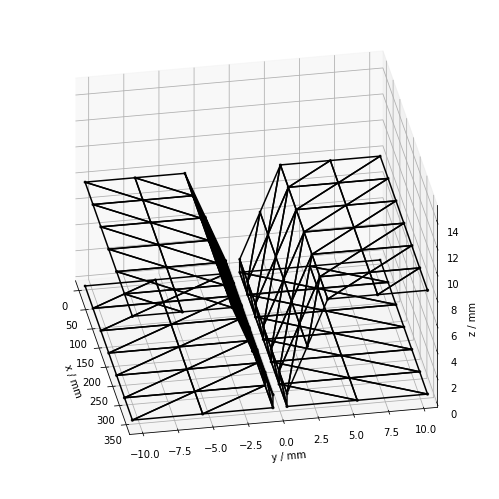

In [17]:
geometry = create_geometry(groove, seam_length, Q_(10, "mm"))
geometry.plot(profile_raster_width=Q_(4, "mm"), trace_raster_width=Q_(60, "mm"))
ax_setup(plt.gca())
fig = plt.gcf()
fig.set_size_inches(7, 7)

## Welding TCP movement description

The path of the welding wire along the weld seam is given by the `TCP` property.

The weld path is a linear movement between two points at a constant weld speed. The TCP reference frame is the workpiece base coordinate system, starting at the beginning of the weld seam. The x-axis coordinates will indicate the start- and end-point of the welding process along the workpiece length. The y- and z-coordinates determine the position of the TCP in relation to the cross-sectional groove plane.

The information is stored in a [LocalCoordinateSystem](https://weldx.readthedocs.io/en/v0.3.3/_autosummary/weldx.transformations.LocalCoordinateSystem.html#weldx.transformations.LocalCoordinateSystem) instance with two points and the start and end time relative to the `reference_timestamp`.

The YAML section of the weldx file describing the TCP movement looks like this:

```yaml
TCP: !<tag:weldx.bam.de:weldx/core/transformations/local_coordinate_system-1.0.0>
  reference_time: !<tag:weldx.bam.de:weldx/time/timestamp-1.0.0> {value: '2021-03-17T11:06:42.334400'}
  time: !<tag:weldx.bam.de:weldx/time/timedeltaindex-1.0.0>
    values: !core/ndarray-1.0.0
      data: [0, 41333333333]
      datatype: int64
      shape: [2]
    start: !<tag:weldx.bam.de:weldx/time/timedelta-1.0.0> {value: 'P0DT0H0M0S'}
    end: !<tag:weldx.bam.de:weldx/time/timedelta-1.0.0> {value: 'P0DT0H0M41.333333333S'}
  coordinates: !<tag:weldx.bam.de:weldx/core/variable-1.0.0>
    name: coordinates
    dimensions: [time, c]
    dtype: <f8
    data: !core/ndarray-1.0.0
      data:
      - [20.0, 0.0, 3.0]
      - [330.0, 0.0, 3.0]
      datatype: float64
      shape: [2, 3]
```

The `data` section of the coordiantes describe the start end end point in 3D space: `[20.0, 0.0, 3.0]` to `[330.0, 0.0, 3.0]` .
Therefor the welded part of the workpiece will extend from 20 mm to 330 mm of the joint. The offset in z-direction is 3 mm from the workpiece bottom.

We can create a `CoordinateSystemManager` instance and add the movement of the welding TCP to the geometry plot:

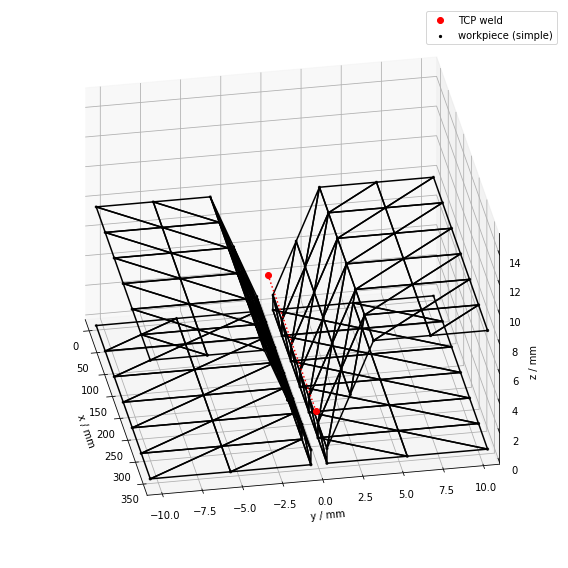

In [18]:
csm_base = build_base_csm(weldx_file, plot=False)
csm_base.plot(
    reference_system="workpiece", coordinate_systems=["TCP weld"],
    data_sets=["workpiece (simple)"], colors=cs_colors,
    show_wireframe=True, show_data_labels=False, show_vectors=False,
)
ax_setup(plt.gca())

## Process description
The arc welding process must be defined using the following properties:
```yaml
process:
  type: object
  properties:
    welding_process:
      $ref: "http://weldx.bam.de/schemas/weldx/process/GMAW-1.0.0"
    shielding_gas:
      tag: "tag:weldx.bam.de:weldx/aws/process/shielding_gas_for_procedure-1.0.0"
    weld_speed:
      ...
    welding_wire:
      ...
  required: [welding_process, shielding_gas, weld_speed, welding_wire]
```

We can store the process property in a new variable:

In [19]:
process = weldx_file["process"]

The weld speed is restricted to a constant value of dimension "[length]/[time]"
```yaml
weld_speed:
  tag: "tag:weldx.bam.de:weldx/core/time_series-1.0.0"
  wx_unit: "m/s"
  wx_shape: [1]
```

In [20]:
process["weld_speed"]

<TimeSeries>
Constant value:
	45
Units:
	centimeter / minute

The welding wire is described by the constant diameter and a string describing the classification.
```yaml
welding_wire:
  type: object
  properties:
    diameter:
      description: |
        The diameter of the welding wire.
      tag: "tag:stsci.edu:asdf/unit/quantity-1.1.0"
      wx_unit: "m"
      wx_shape: [1]
    class:
      type: string
```

Additional metadata can be stored in the `wx_user` field if necessary. In the example, a G4Si1 wire with 1.2 mm diameter was used. The manufacturer and charge number are also given.

In [21]:
process["welding_wire"]

{'class': 'G 42 2 C/M G4Si1',
 'diameter': array(1.2) <Unit('millimeter')>,
 'wx_user': {'charge id': '00349764', 'manufacturer': 'WDI'}}

The shielding gas information consists of a common name and the gas mixture.

In [22]:
pprint(process["shielding_gas"].torch_shielding_gas.__dict__)

{ 'common_name': 'corgon 18',
  'designation': None,
  'gas_component': [ GasComponent(gas_chemical_name='argon', gas_percentage=<Quantity(82, 'percent')>),
                     GasComponent(gas_chemical_name='carbon dioxide', gas_percentage=<Quantity(18, 'percent')>)]}


In [23]:
# switch to static plots
%matplotlib inline

The `welding_process` describes the parameters set at the welding power source during the course of the experiment.

Parameters are represented by a [`TimeSeries`](https://weldx.readthedocs.io/en/v0.3.3/tutorials/timeseries_01.html) object and can vary over time. In this example, all parameters are set to constant values.

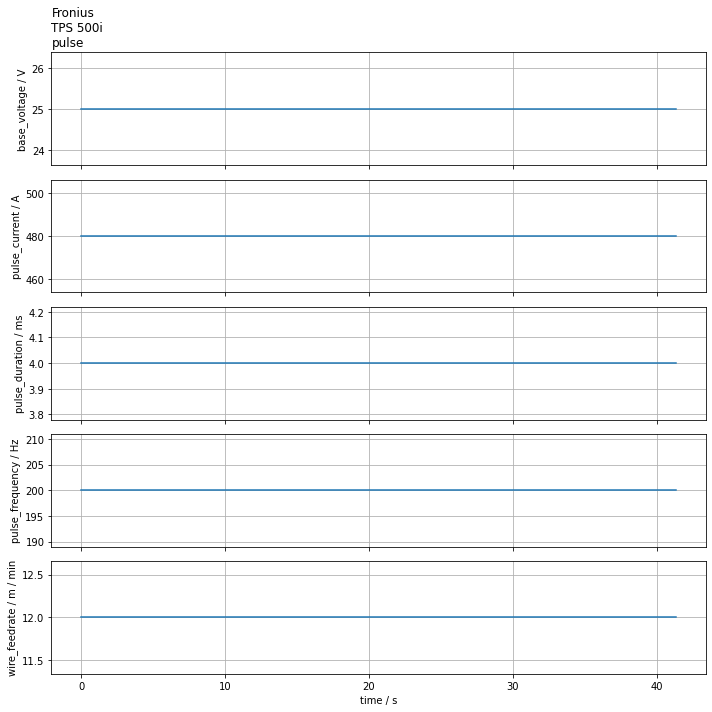

In [24]:
gmaw_process = process["welding_process"]
fig, ax = plot_gmaw(gmaw_process, t)  

## measurements
We can list all measurements stored in the file.

In [25]:
for measurement in weldx_file["measurements"]:
    print(measurement.name)

welding current measurement
welding voltage measurement
temperature measurement T1
temperature measurement T2


We can also create a plot showing all signals stored in the measurement chains listed under `measurements`.

In the example dataset the welding current and voltage are recorded during the welding process. The temperature-measurements are recorded before and after the welding experiment. Due to the use of reference times, all signals can be synchronized. 

C:\Users\vhirtham\Miniconda3\envs\weldx\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\vhirtham\Miniconda3\envs\weldx\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\vhirtham\Miniconda3\envs\weldx\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\vhirtham\Miniconda3\envs\weldx\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


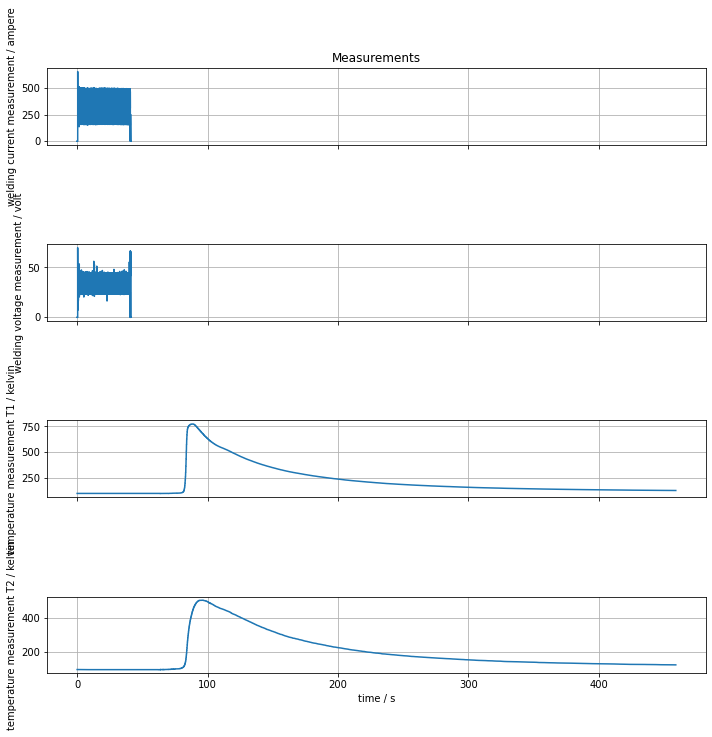

In [26]:
plot_measurements(weldx_file["measurements"], ref_time=weldx_file["reference_timestamp"])

In [27]:
# switch to interactive plots
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

Plot the voltage measurement:

C:\Users\vhirtham\Miniconda3\envs\weldx\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


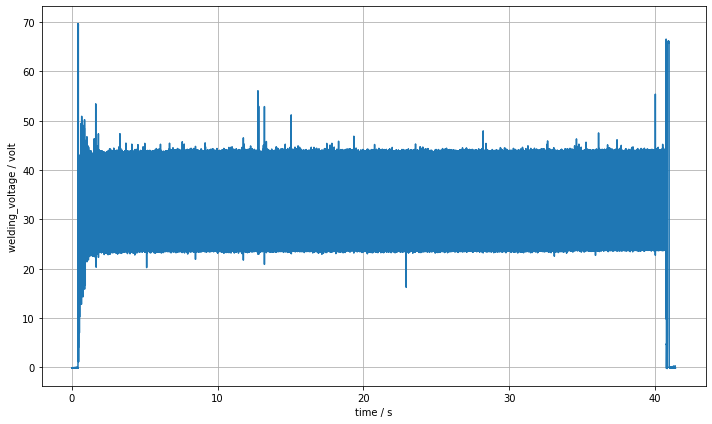

In [29]:
plot_signal(weldx_file["welding_voltage"], "welding_voltage")

Plot the current meausurement:

C:\Users\vhirtham\Miniconda3\envs\weldx\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


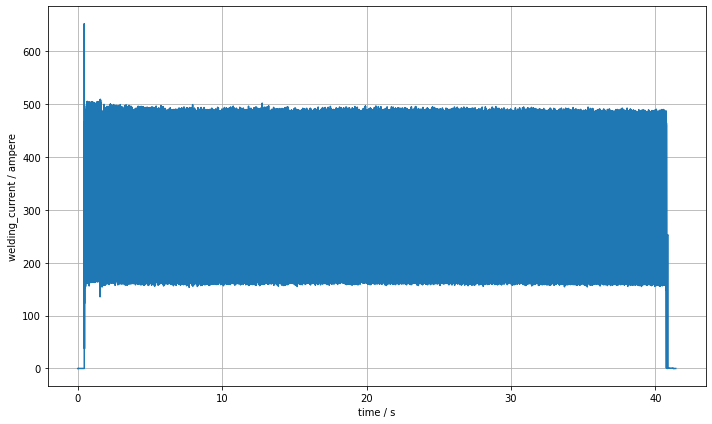

In [30]:
plot_signal(weldx_file["welding_current"], "welding_current")

Here is a detailed look at the current waveform:

C:\Users\vhirtham\Miniconda3\envs\weldx\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


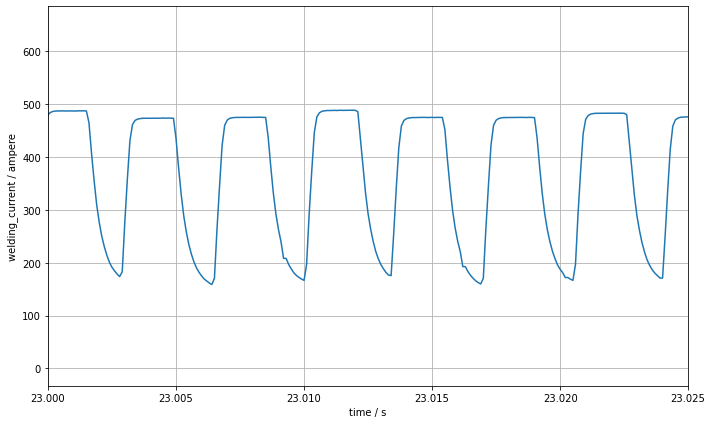

In [31]:
plot_signal(weldx_file["welding_current"], "welding_current",limits=(23, 23.025))

## measurement chains
To document how a welding related measurement was conducted, we can describe and store measurement chains using the `weldx` API.
This includes:
- describing the measurement equipment
- describing multiple transformation steps from raw-data to the final measurement
- providing information about measurement uncertainties and errors
- attaching certification examples or similar files

An in depth example describing measurement chains can be found in the documentation: [meassurement_example](https://weldx.readthedocs.io/en/v0.3.3/tutorials/measurement_example.html)

### current measurement chain

In [34]:
current_measurement_chain = weldx_file["measurements"][0].measurement_chain

current_source = current_measurement_chain.source
print(current_source.name)
for processor in current_measurement_chain.transformations:
    print(processor.name)

Current Sensor
AD current conversion
current calibration


Each measurement chain object can be visualized with it's plot function. The squared nodes represent signals, the circular nodes show data that is present for a single signal. Transformation steps between signals are given with name and some info.

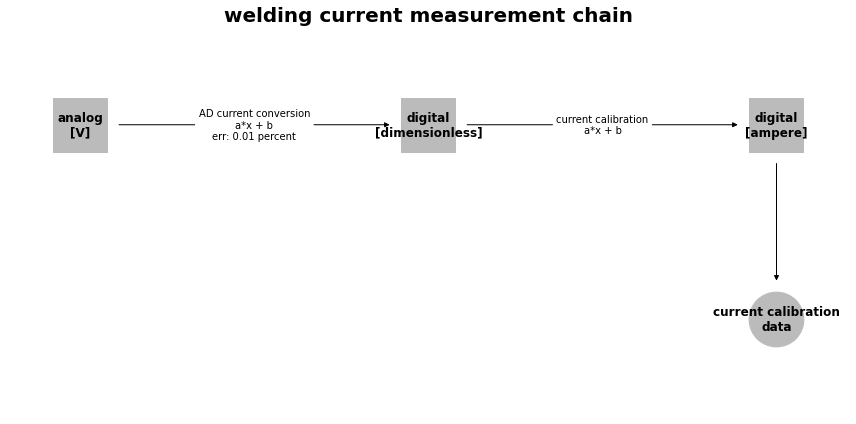

In [35]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
weldx_file["measurements"][0].measurement_chain.plot(ax)
ipympl_style(fig,toolbar=False)

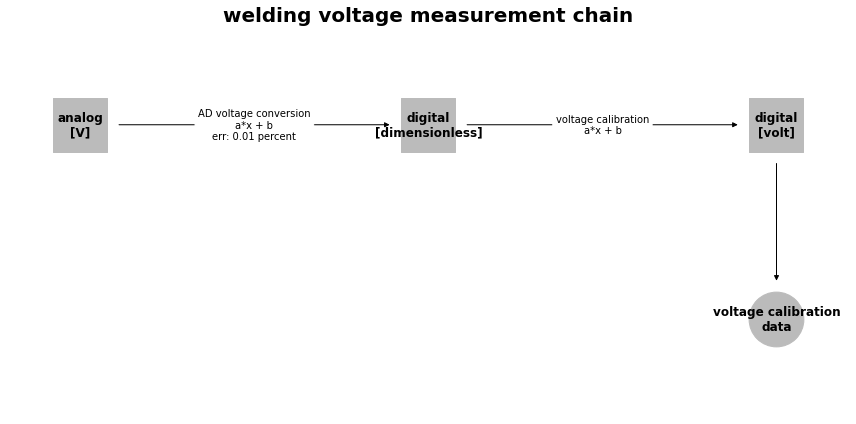

In [36]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
weldx_file["measurements"][1].measurement_chain.plot(ax)
ipympl_style(fig,toolbar=False)

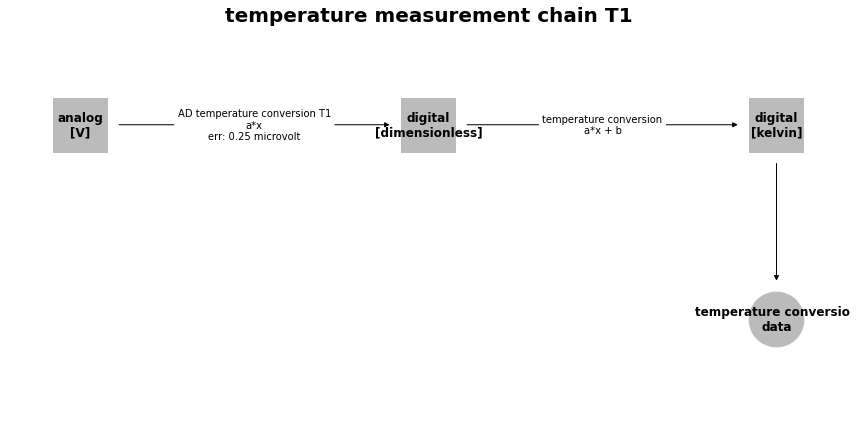

In [37]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
weldx_file["measurements"][2].measurement_chain.plot(ax)
ipympl_style(fig,toolbar=False)

## coordinate systems
The `weldx` API contains multiple functions to describe dependencies and transformations between multiple different coordinate systems.

- translations and rotations
- constant and time dependent transformations
- transformation between different systems
- grouping multiple systems into subsystems
- transforming spatial data between different coordinate systems
- visualization of transformations and systems

There are multiple tutorials available covering coordinate transformations using the `LocalCoordinateSystem` and `CoordinateSystemManager` classes:

- https://weldx.readthedocs.io/en/v0.3.3/tutorials/transformations_01_coordinate_systems.html
- https://weldx.readthedocs.io/en/v0.3.3/tutorials/transformations_02_coordinate_system_manager.html
- https://weldx.readthedocs.io/en/v0.3.3/tutorials/transformations_02_coordinate_system_manager.html#Visualizing-the-coordinate-systems-of-the-CSM
- https://weldx.readthedocs.io/en/v0.3.3/tutorials/welding_example_02_weaving.html

In [38]:
# switch to static plots
%matplotlib inline

In addition to the simplified weldment specification, the example dataset contains the complete coordinate system information describing the BAM arc welding setup.

- the definition of the reference user frame used for robot programming
- the recorded actual TCP movement of the robot
- the movement of a laser line scanner attached to the robot head

We can load the instance of the coordinate system manager directly from the weldx file.\
Following the file schema the data can be accessed under the key `coordinate_systems`.

In [39]:
csm = weldx_file["coordinate_systems"]

We can visualize all loaded coordinate systems using the built-in `plot` functions.

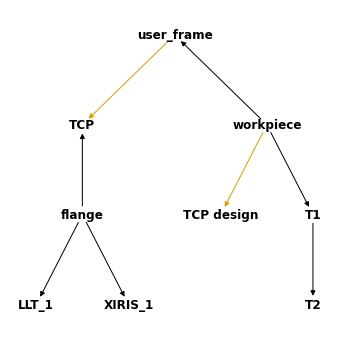

In [40]:
csm.plot_graph()
plt.gcf().set_size_inches(w=6, h=6)

Let's take another look at the weld specimen.

<img src='./data/WID417_pre.JPG' width="640" />

The workpiece coordinate system has it's origin located at the start of the workpiece at groove center. We can calculate the position of the thermocouple placement in the workpiece coordinate system.

In [41]:
csm.get_cs("T1","user_frame")

<LocalCoordinateSystem>
Dimensions:      (c: 3, v: 3)
Coordinates:
  * c            (c) <U1 'x' 'y' 'z'
  * v            (v) int32 0 1 2
Data variables:
    coordinates  (c) float64 155.0 123.5 0.0
    orientation  (v, c) float64 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0

The second thermocouple is offset by 5 mm from the first.

In [42]:
csm.get_cs("T2","T1")

<LocalCoordinateSystem>
Dimensions:      (c: 3, v: 3)
Coordinates:
  * c            (c) <U1 'x' 'y' 'z'
  * v            (v) int32 0 1 2
Data variables:
    coordinates  (c) float64 0.0 5.0 0.0
    orientation  (v, c) float64 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0

The following command will calculate the recorded robot TCP movement in reference to the workpiece coordinate system.
Since the robot movement is time dependent, the result will be a time dependent coordiante system.

In [43]:
csm.get_cs("TCP","workpiece")

<LocalCoordinateSystem>
Dimensions:      (c: 3, time: 5176, v: 3)
Coordinates:
  * c            (c) <U1 'x' 'y' 'z'
  * time         (time) timedelta64[ns] -1 days +23:59:59.515000 ... 00:00:40...
  * v            (v) int32 0 1 2
Data variables:
    coordinates  (time, c) float64 20.0 -0.001147 4.001 ... 329.9 -0.09271 3.973
    orientation  (v, c) float64 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0

### Add geometry data to CSM

For advanced visualization using the `k3d` backend we attach some 3D data to the `CoordinateSystemManager`

In [44]:
geometry_full_width = create_geometry(groove, seam_length, Q_(100, "mm"))
spatial_data_geo_full = geometry_full_width.spatial_data(
    profile_raster_width=Q_(4, "mm"), trace_raster_width=Q_(60, "mm")
)
spatial_data_geo_full.coordinates = spatial_data_geo_full.coordinates.astype("float32")

spatial_data_geo_reduced = geometry.spatial_data(
    profile_raster_width=Q_(4, "mm"), trace_raster_width=Q_(60, "mm")
)

csm.assign_data(spatial_data_geo_full, "workpiece geometry", "workpiece")
csm.assign_data(spatial_data_geo_reduced, "workpiece geometry (reduced)", "workpiece")

Adding 3D measurements of the actual pre- and post-weld workpiece geometry:

*Note: the default scan data in `scans.asdf` are downsampled to limit memory usage. When running a local copy of the notebook the full dataset can be loaded from the file `scans_full.asdf`.*

In [45]:
with asdf.open(f"./data/scans.asdf") as af:
    scans = af.tree
    csm.assign_data(scans["scan_0"], "scan_0", "workpiece")
    csm.assign_data(scans["scan_1"], "scan_1", "workpiece")

We also add a 3D model of the welding wire and attach it to the `TCP` coordinate system. The wire model will follow the TCP movement.

In [46]:
welding_wire_diameter = weldx_file["process"]["welding_wire"]["diameter"].m
csm.assign_data(
    welding_wire_geo_data(welding_wire_diameter / 2, 17, 16), "welding_wire", "TCP"
)

The `weldx` API uses `k3d` for advanced 3D visualization.

Here is an example visualization of the experiment design.\
The reconstruction is entierly based on the metadata stored inside the weldx file.

In [47]:
csm.plot(
    reference_system="workpiece", coordinate_systems=["TCP design", "T1", "T2"],
    data_sets=["workpiece geometry", "welding_wire"], colors=cs_colors,
    show_data_labels=True, backend="k3d",
)

Output()

Here is the same visualization, this time using only actual measurement data for the plot.

The `TCP` motion is taken from the robot recording of the actual TCP during welding operation.\
The workpiece data was obtained from a 3D scan of the workpiece data before and after welding. We can switch the pre- and post-weld scan data for the plot by selecting the corresponding datasets `scan_0` or `scan_1` in the following cell.

In [48]:
csm.plot(
    reference_system="workpiece", coordinate_systems=["TCP", "T1", "T2"],
    data_sets=["scan_0", "welding_wire"], colors=cs_colors,
    show_data_labels=True, backend="k3d",
)

Output()

## A small example

What was the position of the welding process at a specific time (disturbance) of the experiment?

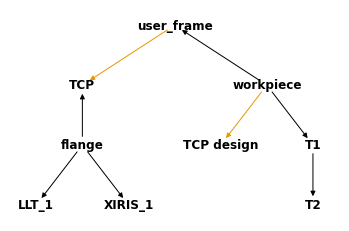

In [49]:
csm

In [50]:
csm.get_cs("TCP","workpiece",time=Q_(30,"s"))

<LocalCoordinateSystem>
Dimensions:      (c: 3, time: 1, v: 3)
Coordinates:
  * c            (c) <U1 'x' 'y' 'z'
  * time         (time) timedelta64[ns] 00:00:30
  * v            (v) int32 0 1 2
Data variables:
    coordinates  (time, c) float64 249.3 -0.1068 3.973
    orientation  (v, c) float64 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0

## Equipment
We can also look into the equipment data of the experiment.

In [52]:
view_tree(filename, ("equipment",))

<IPython.core.display.JSON object>